In [1]:
# Autosave each 30s
%autosave 30

import numpy as np
import pandas as pd
import pickle as pkl
import copy
import gc
import math
import time
import scipy

from scipy import stats
from scipy.special import erfc
from scipy.signal import fftconvolve
from itertools import product, chain
from collections import defaultdict, Counter
from tqdm import tqdm
from __future__ import print_function

#sklearn
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#skimage
import skimage
from skimage import io, transform, color
from skimage.transform import resize

#IPython imports
from IPython.display import Image, display, clear_output
from IPython.core.display import HTML
from IPython.display import FileLink, FileLinks

#matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

#https://matplotlib.org/users/customizing.html
matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.01
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
# Configuring latex fonts
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

%load_ext autoreload
%autoreload 1
# Below comes the list of modules which is automatically reimported
# %aimport cs231n.classifiers.k_nearest_neighbor

_add_to_path = True

Autosaving every 30 seconds


In [2]:
import sys
if _add_to_path:
    sys.path.append('../../')
    _add_to_path = False
    
CIFAR10_DIR = '../../datasets/CIFAR10'
from ml.utils import get_CIFAR10_data, load_CIFAR10
from ml.utils.gradient_check import *
from ml.generators import BatchGenerator
from ml.neighbors import KNearestNeighbor
from ml.linear_model import svm_loss_naive, svm_loss_vectorized, softmax_loss_naive, softmax_loss_vectorized
from ml.linear_model import Softmax, LinearSVM
from ml.neural_network import TwoLayerNet, Sequential, NetworkTrainer
from ml.neural_network.layers import Dense, Dropout, SoftMax
from ml.neural_network.nonlinearities import ReLU, LeakyReLU, ELU, SoftPlus
from ml.neural_network.criterions import MulticlassLogLoss
from ml.images.features import *

In [13]:
import imp
import ml
imp.reload(ml.neighbors.k_nearest_neighbor)
imp.reload(ml.neural_network.two_layer_net)
imp.reload(ml.neural_network.trainer)
imp.reload(ml.neural_network.trainer.trainer)
imp.reload(ml.neural_network.layers)
imp.reload(ml.neural_network.layers.dense)
imp.reload(ml.neural_network.nonlinearities)
imp.reload(ml.neural_network.criterions)
imp.reload(ml.images.features)
imp.reload(ml.utils.data_utils)
imp.reload(ml.utils)

<module 'ml.utils' from '../../ml/utils/__init__.py'>

<a id='toc'></a>
# Table of contents    
* [1. k-Nearest Neighbor (kNN)](#knn)
    * [1.1 Loading and visualizing CIFAR-10](#knn_load)
    * [1.2 Calculating distance matrix](#knn_dists)
        * [1.2.1 Testing performance of matrix calculation](#knn_dists_test)
        * [1.2.2 Visualizing distance matrix](#knn_dists_vis)
    * [1.3 Classifiction](#knn_clf)
    * [1.4 Cross-validation](#knn_cv)
* [2. Multiclass Support Vector Machine](#svm)
    * [2.1 CIFAR-10 data loading and preprocessing](#svm_load)
    * [2.2 Checks](#svm_checks)
    * [2.3 Training with SGD](#svm_train)
    * [2.4 Cross-validation](#svm_cv)
    * [2.5 Visualization](#svm_vis)
* [3. Softmax](#softmax)
    * [3.1 CIFAR-10 data loading and preprocessing](#softmax_load)
    * [3.2 Checks](#softmax_checks)
    * [3.3 Training with SGD](#softmax_train)
    * [3.4 Cross-validation](#softmax_cv)
    * [3.5 Visualization](#softmax_vis)
* [4. Neural Network](#nn)
    * [4.1 Toy example](##nn_toy)
        * [4.1.1 Forward pass](#nn_toy_forward)
            * [4.1.1.1 Forward pass: compute scores](#nn_toy_forward_scores)
            * [4.1.1.2 Forward pass: compute loss](#nn_toy_forward_scores)
        * [4.1.2 Forward pass](#nn_toy_backward)
        * [4.1.3 Training](#nn_toy_training)
    * [4.2 Load CIFAR-10 data](#nn_load)
    * [4.3 Training](#nn_training)
    * [4.4 Debug training](#nn_debug)
    * [4.5 Visualizing](#nn_vis)
    * [4.6 Tuning hyperparameters](#nn_tuning)
    * [4.7 My Neural Network](#my_nn)
        * [4.7.1 Testing](#my_nn_test)
            * [Toy example](#my_nn_toy)
            * [MNIST](#my_nn_mnist)
        * [4.7.2 Loading data](#my_nn_load)
        * [4.7.3 Network](#my_nn_arch)
* [5. Special image features](#features)
    * [5.1 Loading data](#features_load)
    * [5.2 Extracting features](#features_extract)
    * [5.3 Training SVM](#features_train_svm)
    * [5.4 Training TwoLayerNet](#features_train_nn)
    * [5.5 Training My Neural Network](#features_train_nn_my)
    * [5.6 Bonus: Design your own features!](#features_bonus2)
    * [5.7 Bonus: Do something extra!](#features_bonus1)

<a id='knn'></a>
# 1. k-Nearest Neighbor (kNN)<sup>[toc](#toc)</sup>

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

<a id='knn_load'></a>
## 1.1 Loading and visualizing CIFAR-10<sup>[toc](#toc)</sup>

In [1]:
train_size = 5000
test_size  = 500
random_state = 15
output = get_CIFAR10_data(train_size, test_size, val_size=0, 
                          ordered=False, ravel=False, bias_trick=False,
                          substract_mean=False, random_state=random_state,
                          cifar10_dir=CIFAR10_DIR)

X_train = output['X_train']; y_train = output['y_train']
X_test = output['X_test']; y_test = output['y_test']

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

NameError: name 'get_CIFAR10_data' is not defined

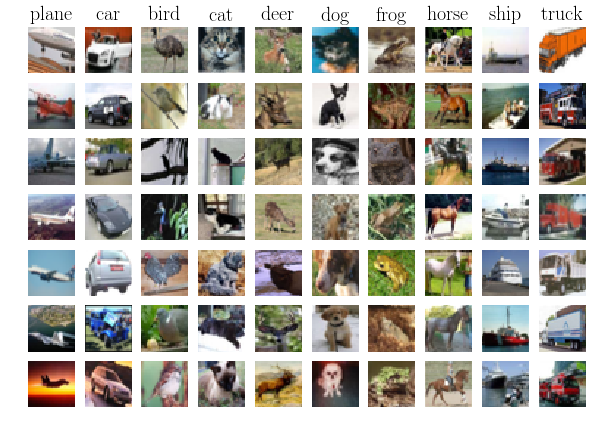

In [10]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

n_cols = num_classes
n_rows = samples_per_class
fsize = 1
f, axarr = plt.subplots(n_rows, n_cols, figsize=(fsize * n_cols, fsize * n_rows))
for n_cls, cls_name in enumerate(classes):
    idxs = np.flatnonzero(y_train == n_cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for n_img, idx in enumerate(idxs):
        axarr[n_img, n_cls].imshow(X_train[idx].astype('uint8'))
        axarr[n_img, n_cls].axis('off')
        if n_img == 0:
            axarr[n_img, n_cls].set_title(cls_name)
plt.show()

In [4]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (5000, 3072)
Training labels shape:  (5000,)
Test data shape:  (500, 3072)
Test labels shape:  (500,)


<a id='knn_dists'></a>
## 1.2 Calculating distance matrix<sup>[toc](#toc)</sup>

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

<a id='knn_dists_test'></a>
### 1.2.1 Testing performance matrix calculation<sup>[toc](#toc)</sup>

In [5]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [23]:
%%time
dists2 = classifier.compute_distances(X_test, num_loops=2)
print(dists2.shape)

(500, 5000)
CPU times: user 43.5 s, sys: 12 ms, total: 43.5 s
Wall time: 43.5 s


In [24]:
%%time
dists1 = classifier.compute_distances(X_test, num_loops=1)
print(dists1.shape)

(500, 5000)
CPU times: user 25.6 s, sys: 9.27 s, total: 34.8 s
Wall time: 34.8 s


In [6]:
%%time
classifier.memory_threshold = 512
dists0 = classifier.compute_distances(X_test, num_loops=0)
print(dists0.shape)

(500, 5000)
CPU times: user 19 s, sys: 5.02 s, total: 24 s
Wall time: 24 s


The same time performance evaluation can be done manually without magic commands:

In [25]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)
one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)
no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

Two loop version took 43.097071 seconds
One loop version took 35.826575 seconds
No loop version took 21.020783 seconds


Let's check that all distance matrices are equal

In [26]:
difference = np.linalg.norm(dists2 - dists1, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

difference = np.linalg.norm(dists2 - dists0, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same
Difference was: 0.000000
Good! The distance matrices are the same


Alternative fast check with `np.allclose`:

In [27]:
rtol = 1e-7; atol=1e-7
assert np.allclose(dists0, dists1, rtol=rtol, atol=atol)
assert np.allclose(dists1, dists2, rtol=rtol, atol=atol)
assert np.allclose(dists2, dists0, rtol=rtol, atol=atol)
dists = dists0
del dists1, dists2

<a id='knn_dists_vis'></a>
### 1.2.2 Visualizing distance matrix<sup>[toc](#toc)</sup>

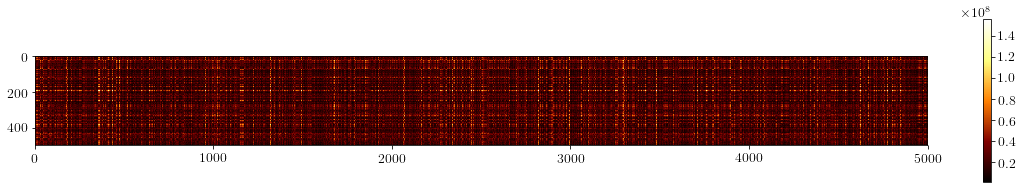

In [36]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
fsize = 20
plt.figure(figsize=(fsize, int(1.5 * fsize * X_test.shape[0] / X_train.shape[0])))
plt.imshow(dists, interpolation='none', cmap='afmhot')
plt.colorbar()
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows? **The distinctly bright rows correpsond to samples in test subset which are significantly differ from the most of images. Probably, these images are generally dark or bright ones, that causes significant L2 distance from from images with average "brightness".**
- What causes the columns? **The outliers in train subset cause the distinctly bright columns.**

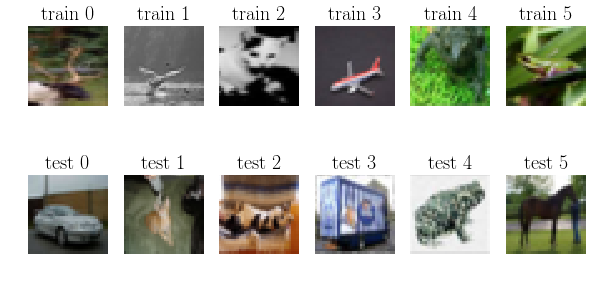

In [44]:
# Drawing outliers in train and test subsets
n_outliers = 6
n_test_outliers = n_outliers 
n_train_outliers = n_outliers 
test_outliers_idx = np.argsort(dists.sum(axis=1))[-n_test_outliers:][::-1]
train_outliers_idx = np.argsort(dists.sum(axis=0))[-n_train_outliers:][::-1]
f, axarr = plt.subplots(2, n_outliers, figsize=(10, 5))
for n in range(n_outliers):
    axarr[0][n].imshow(X_train[n].reshape((32, 32, 3)).astype('uint8'))
    axarr[0][n].axis('off');  axarr[0][n].set_title('train {}'.format(n));
    axarr[1][n].imshow(X_test[n].reshape((32, 32, 3)).astype('uint8'))
    axarr[1][n].axis('off');  axarr[1][n].set_title('test {}'.format(n));

<a id='knn_clf'></a>
## 1.3 Classification<sup>[toc](#toc)</sup>

In [9]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
train_size = X_train.shape[0]
test_size = X_test.shape[0]
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / test_size
print('Got %d / %d correct => accuracy: %f' % (num_correct, test_size, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [10]:
train_size = X_train.shape[0]
test_size = X_test.shape[0]
y_test_pred = classifier.predict_labels(dists, k=5)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / test_size
print('Got %d / %d correct => accuracy: %f' % (num_correct, test_size, accuracy))

Got 154 / 500 correct => accuracy: 0.308000


You should expect to see a slightly better performance than with `k = 1`.

<a id='knn_cv'></a>
## 1.4 Cross-validation<sup>[toc](#toc)</sup>

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [47]:
# Creating folds

train_size, test_size = X_train.shape[0], X_test.shape[0]

n_folds = 5
shuffle = True
seed = 23

k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

splits = []

if shuffle:
    np.random.seed(seed)
    indices = np.random.choice(train_size, train_size, replace=False)
else:
    indices = np.arange(train_size)
indices = indices.astype(np.int32)
indices = np.array_split(indices, n_folds)
for n_fold in range(n_folds):
    test_indices  = indices[n_fold]
    train_indices = np.concatenate([indices[i] for i in range(n_folds) if i != n_fold])
    splits.append((train_indices, test_indices))
    print('n_fold = {}: train_size = {}, test_size = {}'.format(n_fold, len(train_indices), len(test_indices)))

n_fold = 0: train_size = 4000, test_size = 1000
n_fold = 1: train_size = 4000, test_size = 1000
n_fold = 2: train_size = 4000, test_size = 1000
n_fold = 3: train_size = 4000, test_size = 1000
n_fold = 4: train_size = 4000, test_size = 1000


In [48]:
k_to_accuracies = defaultdict(list)
for n_fold, (train_indices, test_indices) in enumerate(splits):
    print('n_fold = {}'.format(n_fold))
    clf = KNearestNeighbor()
    clf.train(X_train[train_indices], y_train[train_indices])
    dists = clf.compute_distances(X_train[test_indices], num_loops=1)
    for k in k_choices:
        y_pred = clf.predict_labels(dists, k=k)
        accuracy = np.mean(y_pred == y_train[test_indices])
        k_to_accuracies[k].append(accuracy)
        print('\tk = {}, accuracy = {}'.format(k, accuracy))

n_fold = 0
	k = 1, accuracy = 0.265
	k = 3, accuracy = 0.265
	k = 5, accuracy = 0.281
	k = 8, accuracy = 0.274
	k = 10, accuracy = 0.276
	k = 12, accuracy = 0.275
	k = 15, accuracy = 0.277
	k = 20, accuracy = 0.268
	k = 50, accuracy = 0.279
	k = 100, accuracy = 0.253
n_fold = 1
	k = 1, accuracy = 0.232
	k = 3, accuracy = 0.228
	k = 5, accuracy = 0.253
	k = 8, accuracy = 0.247
	k = 10, accuracy = 0.249
	k = 12, accuracy = 0.262
	k = 15, accuracy = 0.256
	k = 20, accuracy = 0.241
	k = 50, accuracy = 0.249
	k = 100, accuracy = 0.234
n_fold = 2
	k = 1, accuracy = 0.257
	k = 3, accuracy = 0.233
	k = 5, accuracy = 0.25
	k = 8, accuracy = 0.241
	k = 10, accuracy = 0.251
	k = 12, accuracy = 0.262
	k = 15, accuracy = 0.266
	k = 20, accuracy = 0.257
	k = 50, accuracy = 0.261
	k = 100, accuracy = 0.25
n_fold = 3
	k = 1, accuracy = 0.263
	k = 3, accuracy = 0.252
	k = 5, accuracy = 0.267
	k = 8, accuracy = 0.259
	k = 10, accuracy = 0.258
	k = 12, accuracy = 0.261
	k = 15, accuracy = 0.255
	k = 20, 

k = 1, accuracy = 0.257000
k = 3, accuracy = 0.247200
k = 5, accuracy = 0.261400
k = 8, accuracy = 0.257400
k = 10, accuracy = 0.260200
k = 12, accuracy = 0.264600
k = 15, accuracy = 0.263800
k = 20, accuracy = 0.260800
k = 50, accuracy = 0.258800
k = 100, accuracy = 0.246000


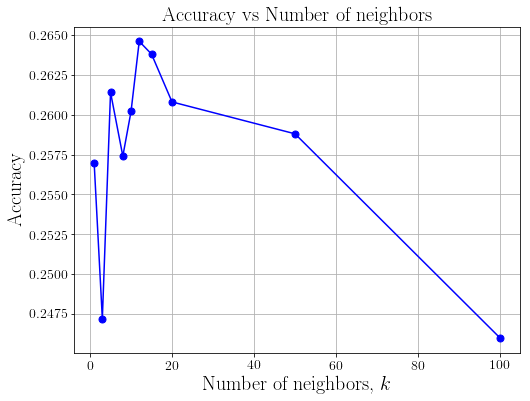

In [49]:
# Print out the computed accuracies
detailed = False
ks = []
accuracies = []
for k in sorted(k_to_accuracies):
    ks.append(k)
    accuracies.append(np.mean(k_to_accuracies[k]))
    if detailed:
        for n_fold, accuracy in enumerate(k_to_accuracies[k]):
            print('k = %d, n_fold = %d, accuracy = %f' % (k, n_fold, accuracy))
    else:
        print('k = %d, accuracy = %f' % (k, np.mean(k_to_accuracies[k])))
        
plt.figure(figsize=(8, 6))
plt.plot(ks, accuracies, marker='o', ms=7, color='b')
plt.grid()
plt.xlabel('Number of neighbors, $k$')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of neighbors');

<a id='svm'></a>
# 2. Multiclass Support Vector Machine<sup>[toc](#toc)</sup>

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

<a id='svm_load'></a>
## 2.1 CIFAR-10 data loading and preprocessing<sup>[toc](#toc)</sup>

In [16]:
# Load the raw CIFAR-10 data. 
X_tr, y_tr, X_ts, y_ts = load_CIFAR10(CIFAR10_DIR)
print(X_tr.shape, y_tr.shape)
print(X_ts.shape, y_ts.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


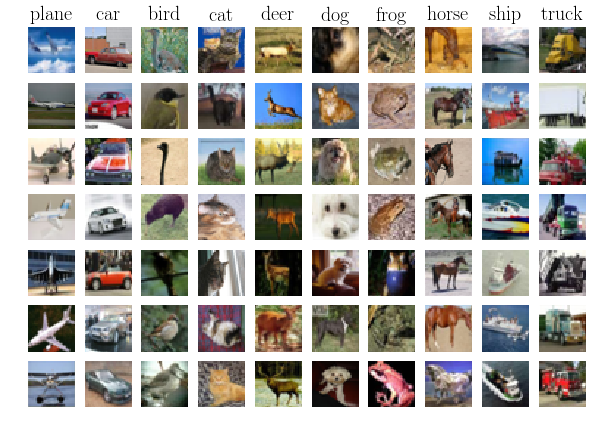

In [17]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

n_cols = num_classes
n_rows = samples_per_class
fsize = 1
f, axarr = plt.subplots(n_rows, n_cols, figsize=(fsize * n_cols, fsize * n_rows))
for n_cls, cls_name in enumerate(classes):
    idxs = np.flatnonzero(y_tr == n_cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for n_img, idx in enumerate(idxs):
        axarr[n_img, n_cls].imshow(X_tr[idx].astype('uint8'))
        axarr[n_img, n_cls].axis('off')
        if n_img == 0:
            axarr[n_img, n_cls].set_title(cls_name)
plt.show()

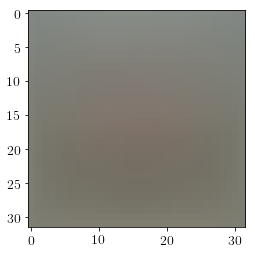

In [19]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_tr, axis=0)
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [4]:
gc.collect()
train_size = 49000
test_size  = 1000
val_size   = 1000
# Invoke the above function to get our data.
output = get_CIFAR10_data(train_size, test_size, val_size, 
                          ravel=True, bias_trick=True, substract_mean=True, random_state=1,
                          cifar10_dir=CIFAR10_DIR)
X_train = output['X_train']; y_train = output['y_train']
X_test = output['X_test']; y_test = output['y_test']
X_val = output['X_val']; y_val = output['y_val']

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)


<a id='svm_checks'></a>
## 2.2 Checks<sup>[toc](#toc)</sup>

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [6]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 
loss, grad = svm_loss_naive(W, X_val, y_val, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.187350


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_val, y_val, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_val, y_val, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_val, y_val, 5e1)
f = lambda w: svm_loss_naive(w, X_val, y_val, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -39.218075 analytic: -39.218075, relative error: 1.366349e-12
numerical: 11.125578 analytic: 11.125578, relative error: 6.123123e-13
numerical: -3.900010 analytic: -3.900010, relative error: 1.053170e-10
numerical: 7.695269 analytic: 7.675597, relative error: 1.279825e-03
numerical: 8.878179 analytic: 8.878179, relative error: 7.985232e-11
numerical: -5.124513 analytic: -5.110858, relative error: 1.334138e-03
numerical: -7.654833 analytic: -7.657832, relative error: 1.957943e-04
numerical: -9.709877 analytic: -9.699856, relative error: 5.162751e-04
numerical: -18.772306 analytic: -18.772306, relative error: 2.160833e-11
numerical: -21.473501 analytic: -21.447803, relative error: 5.987067e-04
numerical: 0.103650 analytic: 0.103650, relative error: 3.637797e-09
numerical: 3.320542 analytic: 3.284167, relative error: 5.507377e-03
numerical: 15.390559 analytic: 15.446712, relative error: 1.820964e-03
numerical: -6.557308 analytic: -6.495544, relative error: 4.731887e-03
numerica

#### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? 

**Your Answer:** It is possible in case when there are several samples which margin is close to 1.0, more exactly, lies in range (1.0 - h, 1.0 + h). In such a case numerically estimated gradient is not correct 
since it estimates $\partial f / \partial x$ as 
$$
\frac{\partial f}{\partial x} = \frac{f(x + h) - f(x - h)}{2h},
$$
which provide wrong result for function $f(x) = (1 - x)_+$ around not differentiable point $x=1$.

In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_val, y_val, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_val, y_val, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

print('difference: %f' % (loss_naive - loss_vectorized))
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.574380s
Vectorized loss and gradient: computed in 0.030215s
difference: -0.000000
difference: 0.000000


<a id='svm_train'></a>
## 2.3 Training with SGD<sup>[toc](#toc)</sup>
We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [15]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, max_iters=2000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

LinearSVM.train: iteration 0 / 2000: loss 793.700175
LinearSVM.train: iteration 100 / 2000: loss 287.391001
LinearSVM.train: iteration 200 / 2000: loss 108.390929
LinearSVM.train: iteration 300 / 2000: loss 42.453281
LinearSVM.train: iteration 400 / 2000: loss 19.228804
LinearSVM.train: iteration 500 / 2000: loss 10.812683
LinearSVM.train: iteration 600 / 2000: loss 7.198593
LinearSVM.train: iteration 700 / 2000: loss 6.492407
LinearSVM.train: iteration 800 / 2000: loss 5.707032
LinearSVM.train: iteration 900 / 2000: loss 4.897170
LinearSVM.train: iteration 1000 / 2000: loss 4.762617
LinearSVM.train: iteration 1100 / 2000: loss 5.282959
LinearSVM.train: iteration 1200 / 2000: loss 5.943071
LinearSVM.train: iteration 1300 / 2000: loss 5.593825
LinearSVM.train: iteration 1400 / 2000: loss 4.959582
LinearSVM.train: iteration 1500 / 2000: loss 4.905448
LinearSVM.train: iteration 1600 / 2000: loss 4.992908
LinearSVM.train: iteration 1700 / 2000: loss 5.258231
LinearSVM.train: iteration 1800

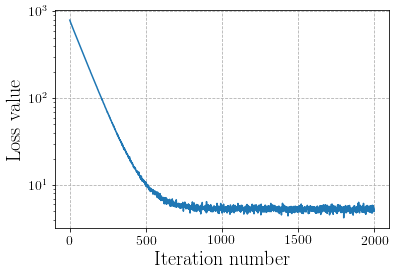

In [16]:
plt.plot(loss_hist)
plt.xlabel('Iteration number'); plt.ylabel('Loss value');
plt.yscale('log');
plt.grid(linestyle='--')

<a id='svm_pred'></a>
### Predicting<sup>[toc](#toc)</sup>

In [17]:
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370429
validation accuracy: 0.332000


<a id='svm_cv'></a>
## 2.4 Cross-validation<sup>[toc](#toc)</sup>

In [60]:
learning_rates = np.logspace(-8, -6, 5)
regularization_strengths = np.linspace(1e4, 4e4, 5)

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for lr, reg in product(learning_rates, regularization_strengths):
    clf = LinearSVM(123)
    clf.train(X_train, y_train, learning_rate=lr, reg=reg, max_iters=1500, tol=1e-4)
    y_pred_train = clf.predict(X_train)
    y_pred_val   = clf.predict(X_val)
    train_accuracy = np.mean(y_pred_train == y_train)
    val_accuracy = np.mean(y_pred_val == y_val)
    print('lr = {:.5e}, reg = {:.4f}: train accuracy = {:.4f}, val accuracy = {:4f}'.format(
        lr, reg, train_accuracy, val_accuracy))
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_svm = clf
        print('\tBest clf updated: train accuracy = {:.4f}, val accuracy = {:4f}'.format(
            train_accuracy, val_accuracy))
print('best validation accuracy achieved during cross-validation: {:.4}'.format(best_val))

lr = 1.00000e-08, reg = 10000.0000: train accuracy = 0.2043, val accuracy = 0.193000
	Best clf updated: train accuracy = 0.2043, val accuracy = 0.193000
lr = 1.00000e-08, reg = 17500.0000: train accuracy = 0.2360, val accuracy = 0.229000
	Best clf updated: train accuracy = 0.2360, val accuracy = 0.229000
lr = 1.00000e-08, reg = 25000.0000: train accuracy = 0.2487, val accuracy = 0.239000
	Best clf updated: train accuracy = 0.2487, val accuracy = 0.239000
lr = 1.00000e-08, reg = 32500.0000: train accuracy = 0.2606, val accuracy = 0.249000
	Best clf updated: train accuracy = 0.2606, val accuracy = 0.249000
lr = 1.00000e-08, reg = 40000.0000: train accuracy = 0.2743, val accuracy = 0.266000
	Best clf updated: train accuracy = 0.2743, val accuracy = 0.266000
lr = 3.16228e-08, reg = 10000.0000: train accuracy = 0.3114, val accuracy = 0.303000
	Best clf updated: train accuracy = 0.3114, val accuracy = 0.303000
lr = 3.16228e-08, reg = 17500.0000: train accuracy = 0.3479, val accuracy = 0.3490

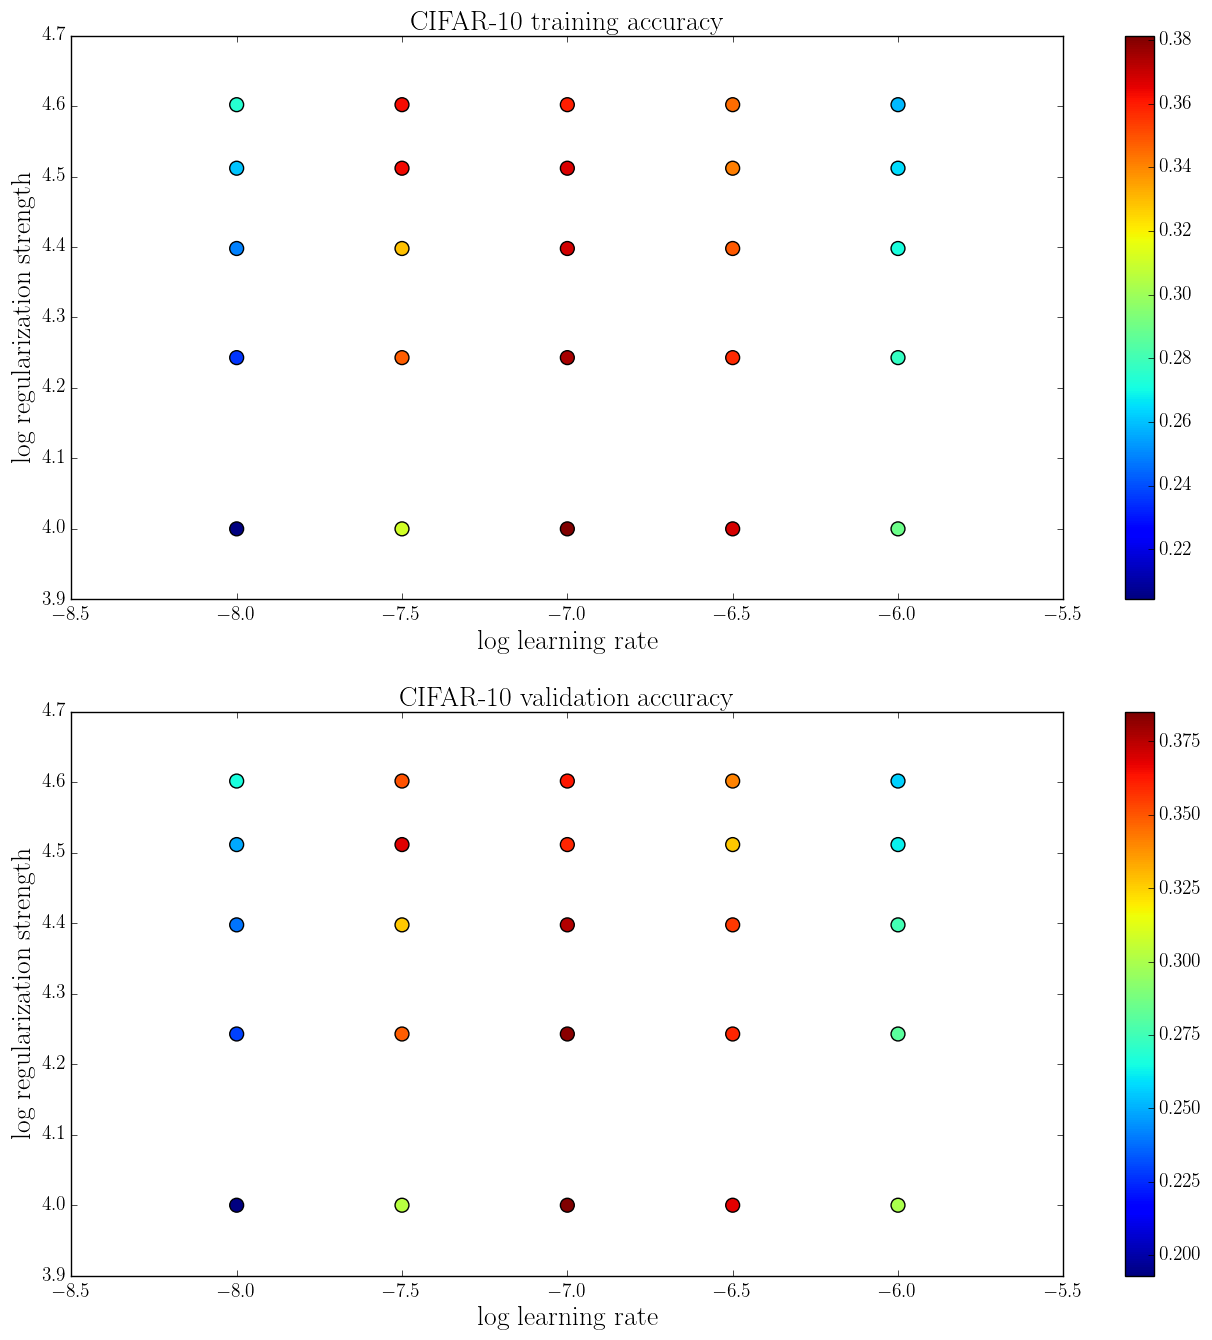

In [63]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]
plt.figure(figsize=(16, 16))
# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate');
plt.ylabel('log regularization strength');
plt.title('CIFAR-10 training accuracy');

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate');
plt.ylabel('log regularization strength');
plt.title('CIFAR-10 validation accuracy');

In [64]:
# Evaluate the best svm on test set
y_test_pred   = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.396000


<a id='svm_vis'></a>
## 2.5 Visualization<sup>[toc](#toc)</sup>

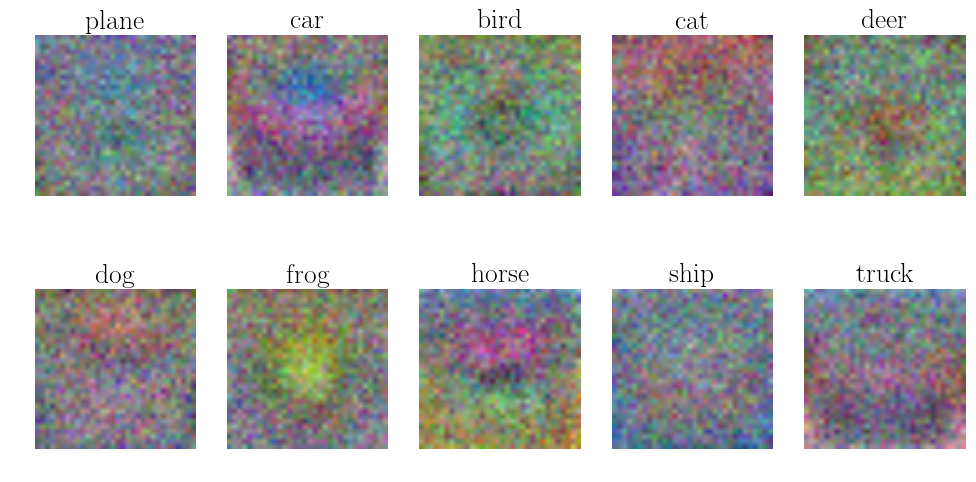

In [67]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** At pictures of car, deer, frog and horse one can even distinguish countours of the corresponding objects. It seems like SVM weights are "averaged" versions of images of the classes. Here "averaged" implies that some representatives from class are chosen and averaged with some weights describing their "typicalness" for this class. Indeed, in such a case correlation of an "averaged" image on an object of the same class is expected to take the highest value among correlations with "averaged" images of other classes resulting in the highest margin for the correct label. 

Certain representative colors can be seen at each of the images: blue for plane, brown for deer, dog and horse, green for from, etc. confirming the suggestion made above. However, image pixels in the same image position differ significantly even inside one class resulting in the observed noise in "averaged" images.

<a id='softmax'></a>
# 3. Softmax<sup>[toc](#toc)</sup>

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

<a id='softmax_load'></a>
### 3.1 CIFAR-10 data loading and preprocessing<sup>[toc](#toc)</sup>

In [86]:
train_size = 49000
test_size  = 1000
val_size   = 1000
# Invoke the above function to get our data.
output = get_CIFAR10_data(train_size, test_size, val_size, 
                          ravel=True, bias_trick=True, substract_mean=True, random_state=1,
                          cifar10_dir=CIFAR10_DIR)
X_train = output['X_train']; y_train = output['y_train']
X_test = output['X_test']; y_test = output['y_test']
X_val = output['X_val']; y_val = output['y_val']

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


<a id='softmax_checks'></a>
## 3.2 Checks<sup>[toc](#toc)</sup>

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 

In [18]:
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_val, y_val, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.364464
sanity check: 2.302585


#### Inline Question 1:
Why do we expect our loss to be close to -log(0.1)?

**Your answer:** At random initialization every of 10 classes is in average equiprobabble, thus
$$
\mathcal{L}(X, y) = -\frac{1}{l}\sum_{i=1}^l \sum_{k=1}^{10} y^i_k \log p^i_k \approx -\frac{1}{l}\sum_{i=1}^l \log (0.1) = -\log(0.1).
$$

In [20]:
loss, grad = softmax_loss_naive(W, X_val, y_val, 0.0)

f = lambda w: softmax_loss_naive(w, X_val, y_val, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

loss, grad = softmax_loss_naive(W, X_val, y_val, 5e1)
f = lambda w: softmax_loss_naive(w, X_val, y_val, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.504547 analytic: -0.504547, relative error: 2.690082e-08
numerical: -1.378017 analytic: -1.378017, relative error: 3.943577e-08
numerical: -1.235563 analytic: -1.235563, relative error: 1.262849e-08
numerical: -0.411734 analytic: -0.411734, relative error: 1.602731e-07
numerical: -2.451484 analytic: -2.451484, relative error: 3.439748e-09
numerical: -0.442900 analytic: -0.442900, relative error: 4.596180e-08
numerical: -1.173558 analytic: -1.173558, relative error: 7.854227e-09
numerical: 0.884055 analytic: 0.884054, relative error: 5.932932e-08
numerical: -3.708863 analytic: -3.708863, relative error: 2.490070e-08
numerical: 1.609040 analytic: 1.609040, relative error: 1.994515e-08
numerical: -1.970651 analytic: -1.970651, relative error: 2.116490e-08
numerical: -2.332764 analytic: -2.332764, relative error: 6.991114e-11
numerical: 1.169709 analytic: 1.169709, relative error: 2.463081e-09
numerical: -0.238684 analytic: -0.238684, relative error: 4.517562e-08
numerical: 1

Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in softmax_loss_vectorized. The two versions should compute the same results, but the vectorized version should be much faster.

In [21]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_val, y_val, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_val, y_val, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.364464e+00 computed in 0.682787s
vectorized loss: 2.364464e+00 computed in 0.020584s
Loss difference: 0.000000
Gradient difference: 0.000000


<a id='softmax_train'></a>
## 3.3 Training with SGD<sup>[toc](#toc)</sup>

In [22]:
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-6, 
                          learning_rate_decay=0.995, 
                          reg=2.5e4, max_iters=10000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

Softmax.train: iteration 0 / 10000: loss 773.354364
Softmax.train: iteration 100 / 10000: loss 2.323812
Softmax.train: iteration 200 / 10000: loss 2.153265
Softmax.train: iteration 300 / 10000: loss 2.073621
Softmax.train: iteration 400 / 10000: loss 2.122202
Softmax.train: iteration 500 / 10000: loss 2.143097
Softmax.train: iteration 600 / 10000: loss 2.110057
Softmax.train: iteration 700 / 10000: loss 2.155294
Softmax.train: iteration 800 / 10000: loss 2.087467
Softmax.train: iteration 900 / 10000: loss 2.035554
Softmax.train: iteration 1000 / 10000: loss 1.994766
Softmax.train: iteration 1100 / 10000: loss 2.075119
Softmax.train: iteration 1200 / 10000: loss 2.135699
Softmax.train: iteration 1300 / 10000: loss 2.101617
Softmax.train: iteration 1400 / 10000: loss 2.042599
Softmax.train: iteration 1500 / 10000: loss 2.046064
Softmax.train: iteration 1600 / 10000: loss 2.049038
Softmax.train: iteration 1700 / 10000: loss 2.065353
Softmax.train: iteration 1800 / 10000: loss 2.085996
Sof

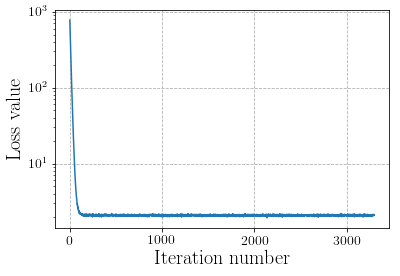

In [23]:
plt.plot(loss_hist)
plt.xlabel('Iteration number'); plt.ylabel('Loss value');
plt.yscale('log');
plt.grid(linestyle='--')

In [24]:
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.328857
validation accuracy: 0.311000


<a id='softmax_cv'></a>
### 3.4 Cross-validation<sup>[toc](#toc)</sup>

Use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over 0.35 on the validation set.

Use the validation set to set the learning rate and regularization strength. This should be identical to the validation that you did for the SVM; save the best trained softmax classifer in best_softmax. 

In [37]:
learning_rates = np.logspace(-8, -6, 5)
regularization_strengths = np.linspace(1e4, 4e4, 5)

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The LinearSVM object that achieved the highest validation rate.

for lr, reg in product(learning_rates, regularization_strengths):
    clf = Softmax(123)
    clf.train(X_train, y_train, learning_rate=lr, learning_rate_decay=0.999, reg=reg, max_iters=1500, tol=1e-4)
    y_pred_train = clf.predict(X_train)
    y_pred_val   = clf.predict(X_val)
    train_accuracy = np.mean(y_pred_train == y_train)
    val_accuracy = np.mean(y_pred_val == y_val)
    print('lr = {:.5e}, reg = {:.4f}: train accuracy = {:.4f}, val accuracy = {:4f}'.format(
        lr, reg, train_accuracy, val_accuracy))
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_softmax = clf
        print('\tBest clf updated: train accuracy = {:.4f}, val accuracy = {:4f}'.format(
            train_accuracy, val_accuracy))
print('best validation accuracy achieved during cross-validation: {:.4}'.format(best_val))

lr = 1.00000e-08, reg = 10000.0000: train accuracy = 0.1287, val accuracy = 0.121000
	Best clf updated: train accuracy = 0.1287, val accuracy = 0.121000
lr = 1.00000e-08, reg = 17500.0000: train accuracy = 0.1106, val accuracy = 0.099000
lr = 1.00000e-08, reg = 25000.0000: train accuracy = 0.1338, val accuracy = 0.129000
	Best clf updated: train accuracy = 0.1338, val accuracy = 0.129000
lr = 1.00000e-08, reg = 32500.0000: train accuracy = 0.1366, val accuracy = 0.132000
	Best clf updated: train accuracy = 0.1366, val accuracy = 0.132000
lr = 1.00000e-08, reg = 40000.0000: train accuracy = 0.1390, val accuracy = 0.134000
	Best clf updated: train accuracy = 0.1390, val accuracy = 0.134000
lr = 3.16228e-08, reg = 10000.0000: train accuracy = 0.1801, val accuracy = 0.175000
	Best clf updated: train accuracy = 0.1801, val accuracy = 0.175000
lr = 3.16228e-08, reg = 17500.0000: train accuracy = 0.1919, val accuracy = 0.184000
	Best clf updated: train accuracy = 0.1919, val accuracy = 0.1840

In [128]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.359000


<a id='softmax_vis'></a>
## 3.5 Visualization<sup>[toc](#toc)</sup>

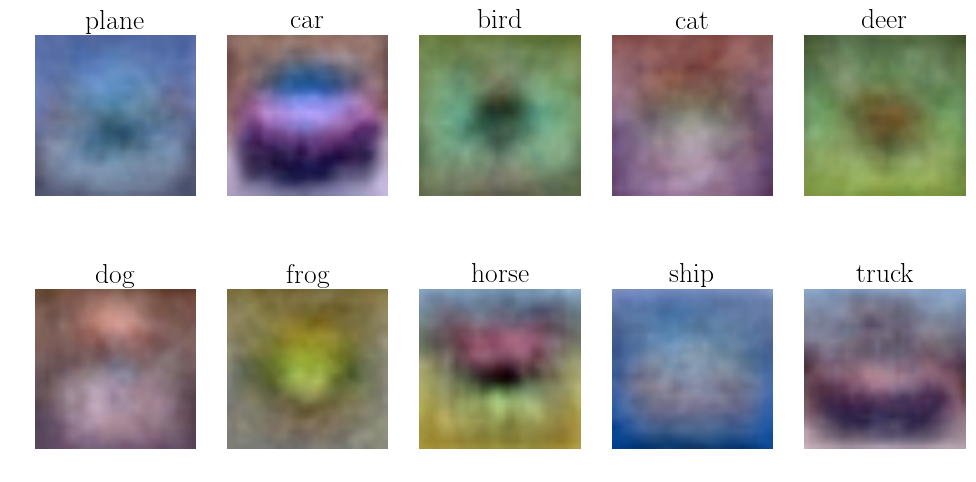

In [115]:
# Visualize the learned weights for each class.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

<a id='nn'></a>
# 4. Neural Network<sup>[toc](#toc)</sup>
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [25]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

<a id='nn_toy'></a>
## 4.1 Toy example<sup>[toc](#toc)</sup>

In [26]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

<a id='nn_toy_forward'></a>
### 4.1.1 Forward pass<sup>[toc](#toc)</sup>

<a id='nn_toy_forward_scores'></a>
#### 4.1.1.1 Forward pass: compute scores<sup>[toc](#toc)</sup>
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [27]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.97746372 -1.07113299 -0.29871249]
 [-0.1664476  -0.42814602  0.45713588]
 [-0.01973389 -0.2134387   0.31257557]
 [ 0.28089869  0.23870094  0.45648123]
 [ 0.10580326  0.18336613  0.23845096]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
7.88545541378


<a id='nn_toy_forward_loss'></a>
#### 4.1.1.2 Forward pass: compute loss<sup>[toc](#toc)</sup>
In the same function, implement the second part that computes the data and regularizaion loss.

In [28]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.103889003061


<a id='nn_toy_backward'></a>
### 4.1.2 Backward pass<sup>[toc](#toc)</sup>
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [30]:
# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    print('Considering param "{}"'.format(param_name))
    def f(param_value):
        net.params[param_name] = param_value
        return net.loss(X, y, reg=0.05)[0]
    param_value = net.params[param_name]
    param_grad_num = eval_numerical_gradient(f, param_value, verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

Considering param "b1"
b1 max relative error: 2.031102e-09
Considering param "W1"
W1 max relative error: 5.249031e-10
Considering param "W2"
W2 max relative error: 2.673196e-10
Considering param "b2"
b2 max relative error: 1.015746e-10


<a id='nn_toy_training'></a>
### 4.1.3 Training <sup>[toc](#toc)</sup>
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. This should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.00848336887843


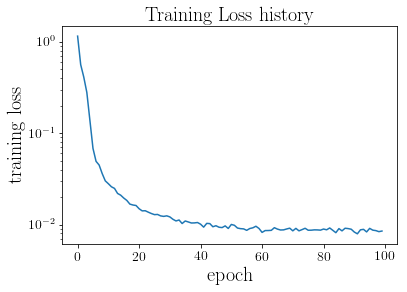

In [31]:
net = init_toy_model()
stats = net.train(X, y, X, y, learning_rate=1e-1, reg=5e-6, n_epochs=100, verbose=False)
print('Final training loss: ', stats['loss_history'][-1])
# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.yscale('log')
plt.show()

<a id='nn_load'></a>
## 4.2 Load CIFAR-10 data<sup>[toc](#toc)</sup>
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [3]:
gc.collect()
train_size = 49000
test_size  = 1000
val_size   = 1000
# Invoke the above function to get our data.
output = get_CIFAR10_data(train_size, test_size, val_size, 
                          ravel=True, bias_trick=False, substract_mean=True, random_state=23,
                          cifar10_dir=CIFAR10_DIR)
X_train = output['X_train']; y_train = output['y_train']
X_test = output['X_test']; y_test = output['y_test']
X_val = output['X_val']; y_val = output['y_val']

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


<a id='nn_training'></a>
## 4.3 Training<sup>[toc](#toc)</sup>
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [72]:
input_size = 32 * 32 * 3
hidden_size = 100
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            n_epochs=100, batch_size=256,
            momentum=0.4, learning_rate=1e-4, learning_rate_decay=0.98,
            reg=1e-4, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

n_epochs = 100, iterations per epoch = 191
	Epoch 0 ended: lr = 0.00010, loss = 2.26314, train acc = 0.2031, val acc = 0.1990
	Epoch 1 ended: lr = 0.00010, loss = 2.08469, train acc = 0.2930, val acc = 0.2430
	Epoch 2 ended: lr = 0.00009, loss = 1.98799, train acc = 0.2852, val acc = 0.2750
	Epoch 3 ended: lr = 0.00009, loss = 1.93679, train acc = 0.2734, val acc = 0.3010
	Epoch 4 ended: lr = 0.00009, loss = 1.90102, train acc = 0.2812, val acc = 0.3240
	Epoch 5 ended: lr = 0.00009, loss = 1.87372, train acc = 0.3320, val acc = 0.3490
	Epoch 6 ended: lr = 0.00009, loss = 1.85610, train acc = 0.3359, val acc = 0.3550
	Epoch 7 ended: lr = 0.00009, loss = 1.84185, train acc = 0.3477, val acc = 0.3490
	Epoch 8 ended: lr = 0.00008, loss = 1.81065, train acc = 0.2930, val acc = 0.3630
	Epoch 9 ended: lr = 0.00008, loss = 1.80065, train acc = 0.3438, val acc = 0.3660
	Epoch 10 ended: lr = 0.00008, loss = 1.78794, train acc = 0.3555, val acc = 0.3710
	Epoch 11 ended: lr = 0.00008, loss = 1.784

	Epoch 98 ended: lr = 0.00001, loss = 1.65967, train acc = 0.4727, val acc = 0.4290
	Epoch 99 ended: lr = 0.00001, loss = 1.65549, train acc = 0.4180, val acc = 0.4340
Validation accuracy:  0.434


<a id='nn_debug'></a>
## 4.4 Debug training<sup>[toc](#toc)</sup>
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

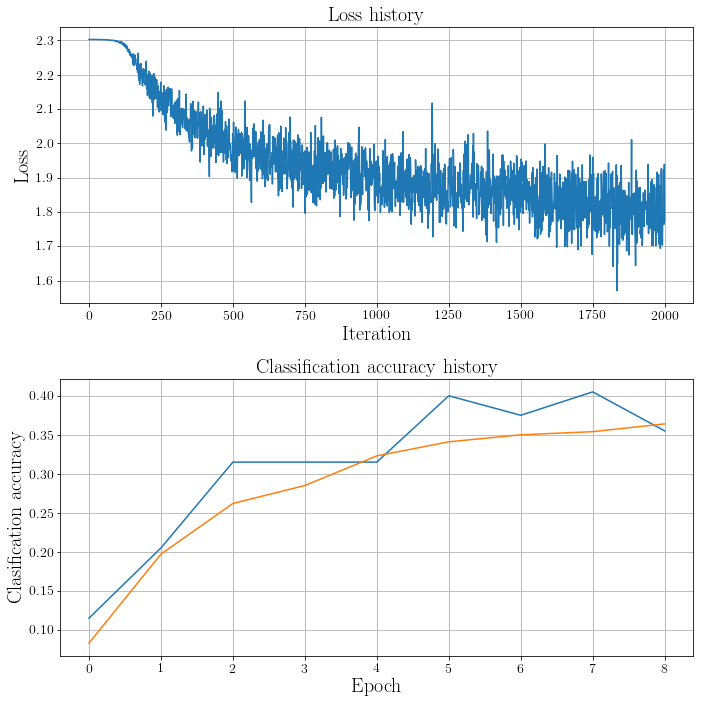

In [20]:
# Plot the loss function and train / validation accuracies
f, axarr = plt.subplots(2, 1, figsize=(10, 10))
ax = axarr[0]
ax.plot(stats['loss_history'], zorder=2)
ax.set_title('Loss history')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.grid()

ax = axarr[1]
ax.plot(stats['train_acc_history'], label='train', zorder=2)
ax.plot(stats['val_acc_history'], label='val', zorder=2)
ax.set_title('Classification accuracy history')
ax.set_xlabel('Epoch')
ax.set_ylabel('Clasification accuracy')
ax.grid()
plt.tight_layout()

<a id='nn_vis'></a>
## 4.5 Visualizing<sup>[toc](#toc)</sup>
Visualize the weights of the network.

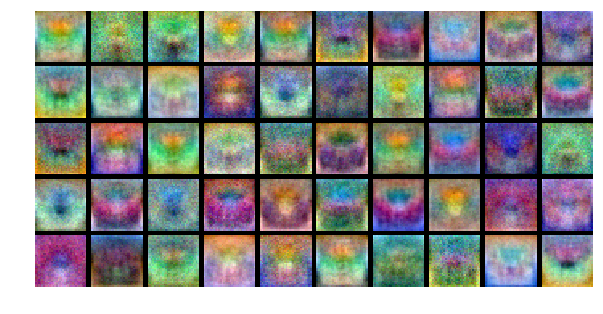

In [46]:
# from cs231n.vis_utils import visualize_grid

W1 = net.params['W1']
W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
plt.figure(figsize=(10, 10))
plt.imshow(visualize_grid(W1, padding=3, n_cols=10).astype('uint8'))
plt.gca().axis('off')
plt.show()

<a id='nn_tuning'></a>
## 4.6 Tuning hyperparameters<sup>[toc](#toc)</sup>

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [ ]:
hidden_size_range = list(range(10, 91, 20))
reg_range = np.logspace(-6, -4, 4)
lr_range = np.logspace(-4, -1, 7)
input_size = X_train.shape[1]
output_size = 10
hidden_size = 100
momentum = 0.1
learning_rate_decay = 0.99

best_params = {}
val_acc_best = -1

for reg, hidden_size, learning_rate in product(reg_range, hidden_size_range, lr_range):
    print('reg = {}, h = {}'.format(reg, hidden_size))
    nn = TwoLayerNet(input_size, hidden_size, output_size, std=1e-4)
    history = nn.train(X_train, y_train, X_val, y_val, 
                       momentum, learning_rate, learning_rate_decay,
                       reg=reg, batch_size=256, 
                       n_epochs=100, verbose=True)
    val_acc_max = np.max(history['val_acc_history'])
    if val_acc_max > val_acc_best:
        val_acc_best = val_acc_max
        best_params['lr'] = learning_rate
        best_params['lr_decay'] = learning_rate_decay
        best_params['momentum'] = momentum
        best_params['reg'] = reg
        best_params['hidden_size'] = hidden_size
        print('new best acc: {}, best params: {}'.format(val_acc_best, best_params))
    print('\n')

reg = 1e-06, h = 10
n_epochs = 100, iterations per epoch = 191
	Epoch 0 ended: lr = 0.00010, loss = 2.29365, train acc = 0.1758, val acc = 0.1690
	Epoch 1 ended: lr = 0.00010, loss = 2.13281, train acc = 0.2852, val acc = 0.2180
	Epoch 2 ended: lr = 0.00010, loss = 2.02660, train acc = 0.3047, val acc = 0.2620
	Epoch 3 ended: lr = 0.00010, loss = 1.95920, train acc = 0.2930, val acc = 0.2930
	Epoch 4 ended: lr = 0.00010, loss = 1.92843, train acc = 0.3398, val acc = 0.3060
	Epoch 5 ended: lr = 0.00009, loss = 1.90388, train acc = 0.2852, val acc = 0.3150
	Epoch 6 ended: lr = 0.00009, loss = 1.88420, train acc = 0.3203, val acc = 0.3220
	Epoch 7 ended: lr = 0.00009, loss = 1.85686, train acc = 0.3320, val acc = 0.3300
	Epoch 8 ended: lr = 0.00009, loss = 1.83470, train acc = 0.3281, val acc = 0.3330
	Epoch 9 ended: lr = 0.00009, loss = 1.81513, train acc = 0.3398, val acc = 0.3430
	Epoch 10 ended: lr = 0.00009, loss = 1.80926, train acc = 0.3867, val acc = 0.3490
	Epoch 11 ended: lr = 0

	Epoch 97 ended: lr = 0.00004, loss = 1.64103, train acc = 0.5000, val acc = 0.4170
	Epoch 98 ended: lr = 0.00004, loss = 1.64290, train acc = 0.4648, val acc = 0.4170
	Epoch 99 ended: lr = 0.00004, loss = 1.63451, train acc = 0.4883, val acc = 0.4140
new best acc: 0.421, best params: {'momentum': 0.1, 'reg': 9.9999999999999995e-07, 'lr': 0.0001, 'lr_decay': 0.99, 'hidden_size': 10}


reg = 1e-06, h = 10
n_epochs = 100, iterations per epoch = 191
	Epoch 0 ended: lr = 0.00031, loss = 2.14811, train acc = 0.2891, val acc = 0.2560
	Epoch 1 ended: lr = 0.00031, loss = 1.92646, train acc = 0.3867, val acc = 0.3120
	Epoch 2 ended: lr = 0.00031, loss = 1.85576, train acc = 0.4023, val acc = 0.3300
	Epoch 3 ended: lr = 0.00030, loss = 1.80015, train acc = 0.3711, val acc = 0.3620
	Epoch 4 ended: lr = 0.00030, loss = 1.77666, train acc = 0.4062, val acc = 0.3660
	Epoch 5 ended: lr = 0.00030, loss = 1.75121, train acc = 0.4219, val acc = 0.3870
	Epoch 6 ended: lr = 0.00029, loss = 1.74905, train

In [52]:
# Predict on the validation set
val_acc = (nn.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

Validation accuracy:  0.406


In [ ]:
# visualize the weights of the best network
best_net = None # store the best model into this 
show_net_weights(best_net)

#### Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

**We will give you extra bonus point for every 1% of accuracy above 52%.**

In [ ]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

<a id='my_nn'></a>
## 4.7 My Neural Net<sup>[toc](#toc)</sup>

<a id='my_nn_test'></a>
### 4.7.1 Testing<sup>[toc](#toc)</sup>

<a id='my_nn_toy'></a>
#### Toy example<sup>[toc](#toc)</sup>

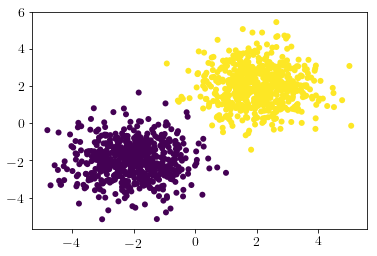

In [3]:
# Generate some data
N = 600

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])
Y = np.concatenate([np.ones(N),np.zeros(N)])[:, None]
Y = np.hstack([Y, 1 - Y]).astype(np.int32)
X = np.vstack([X1, X2])
plt.scatter(X[:, 0], X[:, 1], c=Y[:, 0], edgecolors='none')

In [8]:
net = Sequential()
net.add(Dense(2, 2))
net.add(SoftMax())
criterion = MulticlassLogLoss(2)
print(net)

learning_rate = 1e-2
momentum = 0.1
n_epochs = 100
batch_size = 1200
trainer = NetworkTrainer(net, criterion, learning_rate=learning_rate, momentum=momentum)
model = trainer(X, Y, n_epochs, batch_size=batch_size, verbose=True, 
                eval_sets=[('train', (X, Y))], eval_funcs=['accuracy', 'mlogloss'])

Dense(2->2)
SoftMax
n_epoch=0: [train|loss=0.66108] [train|accuracy=0.63917] [train|mlogloss=0.62870]
n_epoch=1: [train|loss=0.62870] [train|accuracy=0.67417] [train|mlogloss=0.59883]
n_epoch=2: [train|loss=0.59883] [train|accuracy=0.70000] [train|mlogloss=0.57123]
n_epoch=3: [train|loss=0.57123] [train|accuracy=0.74167] [train|mlogloss=0.54572]
n_epoch=4: [train|loss=0.54572] [train|accuracy=0.77083] [train|mlogloss=0.52211]
n_epoch=5: [train|loss=0.52211] [train|accuracy=0.80083] [train|mlogloss=0.50022]
n_epoch=6: [train|loss=0.50022] [train|accuracy=0.81917] [train|mlogloss=0.47991]
n_epoch=7: [train|loss=0.47991] [train|accuracy=0.83250] [train|mlogloss=0.46104]
n_epoch=8: [train|loss=0.46104] [train|accuracy=0.85000] [train|mlogloss=0.44347]
n_epoch=9: [train|loss=0.44347] [train|accuracy=0.86583] [train|mlogloss=0.42710]
n_epoch=10: [train|loss=0.42710] [train|accuracy=0.87667] [train|mlogloss=0.41181]
n_epoch=11: [train|loss=0.41181] [train|accuracy=0.88667] [train|mlogloss=0.3

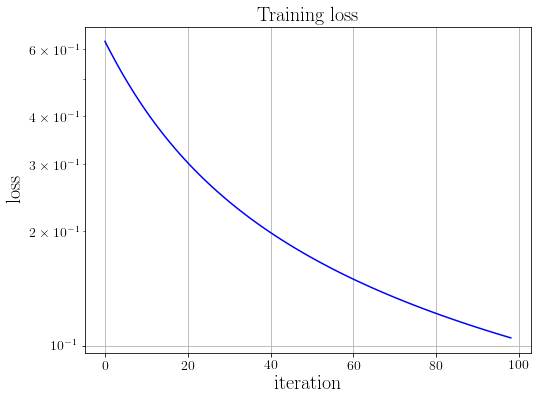

In [9]:
clear_output(wait=True)
plt.figure(figsize=(8, 6))
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.yscale('log')
plt.grid()
plt.plot(model.loss_history[1:], 'b')

<a id='my_nn_mnist'></a>
####  MNIST<sup>[toc](#toc)</sup>

In [10]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)
y = y.astype(np.int32)
Y = np.eye(np.max(y) + 1)[y]

In [11]:
print(X.shape, Y.shape)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, stratify=y, random_state=235)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(70000, 784) (70000, 10)
(56000, 784) (56000, 10)
(14000, 784) (14000, 10)


In [13]:
sequential = Sequential()
sequential.add(Dense(784, 50))
sequential.add(Dropout(0.0))
sequential.add(ELU())
sequential.add(Dense(50, 10))
sequential.add(SoftMax())
criterion = MulticlassLogLoss(10)

learning_rate = 1e-3
momentum = 0.1

trainer = NetworkTrainer(sequential, criterion, learning_rate=learning_rate, momentum=momentum)
eval_funcs = ['mlogloss', 'accuracy']
eval_sets  = [('train', (X_train, Y_train)), ('val', (X_val, Y_val))]
model = trainer(X_train, Y_train, n_epochs=20, batch_size=100, 
                eval_sets=eval_sets, eval_funcs=eval_funcs,
                random_state=234, verbose=True)

n_epoch=0: [train|loss=2.21337] [train|mlogloss=2.12180] [train|accuracy=0.52439] [val|mlogloss=2.12159] [val|accuracy=0.52436]
n_epoch=1: [train|loss=2.03143] [train|mlogloss=1.93930] [train|accuracy=0.66405] [val|mlogloss=1.93850] [val|accuracy=0.66436]
n_epoch=2: [train|loss=1.84488] [train|mlogloss=1.74873] [train|accuracy=0.70482] [val|mlogloss=1.74740] [val|accuracy=0.70900]
n_epoch=3: [train|loss=1.65264] [train|mlogloss=1.55669] [train|accuracy=0.72986] [val|mlogloss=1.55487] [val|accuracy=0.73500]
n_epoch=4: [train|loss=1.46511] [train|mlogloss=1.37589] [train|accuracy=0.75180] [val|mlogloss=1.37366] [val|accuracy=0.75650]
n_epoch=5: [train|loss=1.29463] [train|mlogloss=1.21713] [train|accuracy=0.77332] [val|mlogloss=1.21465] [val|accuracy=0.77829]
n_epoch=6: [train|loss=1.14904] [train|mlogloss=1.08490] [train|accuracy=0.79134] [val|mlogloss=1.08234] [val|accuracy=0.79400]
n_epoch=7: [train|loss=1.02971] [train|mlogloss=0.97796] [train|accuracy=0.80612] [val|mlogloss=0.97539]

<a id='my_nn_load'></a>
## 4.7.2 Loading data<sup>[toc](#toc)</sup>

In [2]:
train_size = 49000
val_size = 1000
test_size = 1000

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(train_size, val_size, test_size, 23)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


In [14]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
Y_train = np.eye(10)[y_train.astype(np.int32)]
Y_val   = np.eye(10)[y_val.astype(np.int32)]
Y_test  = np.eye(10)[y_test.astype(np.int32)]
print(Y_train.shape, Y_val.shape, Y_test.shape)

(49000, 3072) (49000,)
(1000, 3072) (1000,)
(49000, 10) (1000, 10)


<a id='my_nn_arch'></a>
### 4.7.3 Network<sup>[toc](#toc)</sup>

In [23]:
net = Sequential()
net.add(Dense(X_train.shape[1], 200, l2_W_reg=1e-5))
net.add(Dropout(0.5))
net.add(ReLU())
net.add(Dense(200, 10, l2_W_reg=1e-5))
net.add(SoftMax())
criterion = MulticlassLogLoss()

lr = 1e-5
momentum = 0.2

trainer = NetworkTrainer(net, criterion, learning_rate=lr, momentum=momentum)
eval_funcs = [('logloss', logloss), ('acc', accuracy)]
eval_sets  = [('train', (X_train, Y_train)), ('val', (X_val, Y_val))]
model = trainer(X_train, Y_train, n_epochs=100, batch_size=100, 
                eval_sets=eval_sets, eval_funcs=eval_funcs,
                random_state=234, verbose=True)

n_epoch=0: [train|loss=4.05061] [train|logloss=1.59453] [train|acc=0.44163] [val|logloss=1.63631] [val|acc=0.43300]
n_epoch=1: [train|loss=1.78537] [train|logloss=1.57633] [train|acc=0.44251] [val|logloss=1.62838] [val|acc=0.43500]
n_epoch=2: [train|loss=1.71258] [train|logloss=1.51963] [train|acc=0.46839] [val|logloss=1.58125] [val|acc=0.45400]
n_epoch=3: [train|loss=1.68499] [train|logloss=1.49518] [train|acc=0.47537] [val|logloss=1.57618] [val|acc=0.45700]
n_epoch=4: [train|loss=1.67135] [train|logloss=1.49483] [train|acc=0.47214] [val|logloss=1.56557] [val|acc=0.46700]
n_epoch=5: [train|loss=1.64724] [train|logloss=1.44805] [train|acc=0.49580] [val|logloss=1.53863] [val|acc=0.47200]
n_epoch=6: [train|loss=1.62785] [train|logloss=1.43299] [train|acc=0.49506] [val|logloss=1.52470] [val|acc=0.48100]
n_epoch=7: [train|loss=1.61270] [train|logloss=1.42384] [train|acc=0.49935] [val|logloss=1.51863] [val|acc=0.48200]
n_epoch=8: [train|loss=1.59946] [train|logloss=1.40117] [train|acc=0.511

n_epoch=71: [train|loss=1.29886] [train|logloss=1.03016] [train|acc=0.65541] [val|logloss=1.42709] [val|acc=0.51000]
n_epoch=72: [train|loss=1.29983] [train|logloss=1.02533] [train|acc=0.65414] [val|logloss=1.42872] [val|acc=0.50700]
n_epoch=73: [train|loss=1.30216] [train|logloss=1.01549] [train|acc=0.65965] [val|logloss=1.41684] [val|acc=0.51700]
n_epoch=74: [train|loss=1.29335] [train|logloss=1.00552] [train|acc=0.66624] [val|logloss=1.39390] [val|acc=0.52300]
n_epoch=75: [train|loss=1.28874] [train|logloss=1.00477] [train|acc=0.66582] [val|logloss=1.42693] [val|acc=0.50900]
n_epoch=76: [train|loss=1.29268] [train|logloss=1.00716] [train|acc=0.67016] [val|logloss=1.41450] [val|acc=0.52800]
n_epoch=77: [train|loss=1.28922] [train|logloss=1.00116] [train|acc=0.66900] [val|logloss=1.41251] [val|acc=0.52200]
n_epoch=78: [train|loss=1.29102] [train|logloss=1.00799] [train|acc=0.66014] [val|logloss=1.43079] [val|acc=0.50600]
n_epoch=79: [train|loss=1.28673] [train|logloss=1.00808] [train|

<a id='features'></a>
# 5. Image features<sup>[toc](#toc)</sup>
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

<a id='features_load'></a>
## 5.1 Loading CIFAR-10 data<sup>[toc](#toc)</sup>

In [3]:
train_size = 49000
test_size  = 1000
val_size   = 1000
# Invoke the above function to get our data.
output = get_CIFAR10_data(train_size, test_size, val_size, 
                           ravel=False, bias_trick=True, substract_mean=False, random_state=1,
                           cifar10_dir=CIFAR10_DIR)
X_train = output['X_train']; y_train = output['y_train']
X_test = output['X_test']; y_test = output['y_test']
X_val = output['X_val']; y_val = output['y_val']

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
(49000, 32, 32, 3) (49000,)
(1000, 32, 32, 3) (1000,)
(1000, 32, 32, 3) (1000,)


<a id='features_extract'></a>
## 5.2 Extracting features<sup>[toc](#toc)</sup>
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
num_color_bins = 10 # Number of bins in the color histogram
hog_calculator = HogCalculator(n_orientations=9, full_circle=False)
feature_fns = [hog_calculator, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])
print('X_train_feats.shape', X_train_feats.shape)
print('X_val_feats.shape  ', X_val_feats.shape)
print('X_test_feats.shape ', X_test_feats.shape)

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

<a id='features_train_svm'></a>
## 5.3 Training SVM on special image features<sup>[toc](#toc)</sup>
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength
# from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.linspace(1e-7, 10e-7, 10)
regularization_strengths = np.linspace(1e4, 1e5, 10)

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
verbose = False

for lr, reg in product(learning_rates, regularization_strengths):
    clf = LinearSVM(121)
    clf.train(X_train_feats, y_train, learning_rate=lr, learning_rate_decay=0.999, reg=reg, max_iters=5000, tol=1e-7)
    y_pred_train   = clf.predict(X_train_feats)
    y_pred_val     = clf.predict(X_val_feats)
    train_accuracy = np.mean(y_pred_train == y_train)
    val_accuracy   = np.mean(y_pred_val == y_val)
    if verbose:
        print('lr = {:.5e}, reg = {:.4f}: train accuracy = {:.4f}, val accuracy = {:4f}'.format(
            lr, reg, train_accuracy, val_accuracy))
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_svm = clf
        print('\tBest clf updated: train accuracy = {:.4f}, val accuracy = {:4f}'.format(
            train_accuracy, val_accuracy))
print('best validation accuracy achieved during cross-validation: {:.4}'.format(best_val))


print('learning rate = {}, reg = {}'.format(best_svm.learning_rate_init, best_svm.reg))

	Best clf updated: train accuracy = 0.1510, val accuracy = 0.155000
	Best clf updated: train accuracy = 0.2363, val accuracy = 0.249000
	Best clf updated: train accuracy = 0.3745, val accuracy = 0.388000
	Best clf updated: train accuracy = 0.4119, val accuracy = 0.408000
	Best clf updated: train accuracy = 0.4124, val accuracy = 0.410000
	Best clf updated: train accuracy = 0.4134, val accuracy = 0.412000
	Best clf updated: train accuracy = 0.4141, val accuracy = 0.422000
	Best clf updated: train accuracy = 0.4141, val accuracy = 0.425000
best validation accuracy achieved during cross-validation: 0.425
learning rate = 5e-07, reg = 30000.0


In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


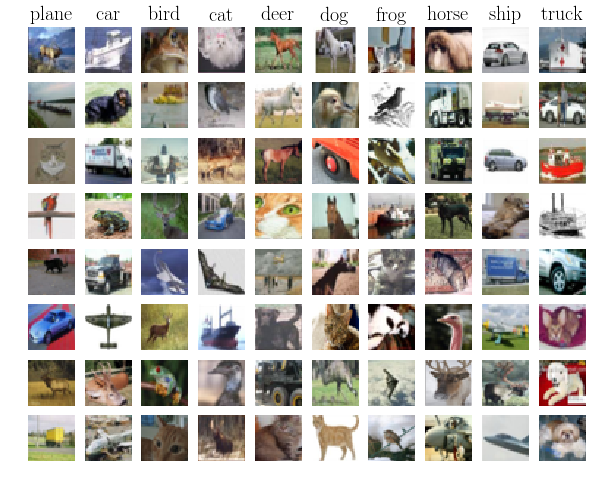

In [10]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
plt.figure(figsize=(10, 8))
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)

#### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

<a id='features_train_nn'></a>
## 5.4 Training TwoLayerNet<sup>[toc](#toc)</sup>

Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [5]:
print(X_train_feats.shape, y_train.shape)
print(X_val_feats.shape, y_val.shape)

(49000, 155) (49000,)
(1000, 155) (1000,)


In [22]:
input_dim = X_train_feats.shape[1]
hidden_dim = 200
num_classes = 10
net = TwoLayerNet(input_dim, hidden_dim, num_classes)

In [29]:
lr = 1e-3
lr_decay = 0.999
history = net.train(X_train_feats, y_train, X_val_feats, y_val, n_epochs=100,
          momentum=0.9, learning_rate=lr, learning_rate_decay=lr_decay, reg=1e-7, batch_size=1000, verbose=True)
best_net = net

n_epochs = 100, iterations per epoch = 49
	Epoch 0 ended: lr = 0.00100, loss = 1.31582, train acc = 0.5700, val acc = 0.5320
	Epoch 1 ended: lr = 0.00100, loss = 1.31978, train acc = 0.5320, val acc = 0.5320
	Epoch 2 ended: lr = 0.00100, loss = 1.31175, train acc = 0.5230, val acc = 0.5320
	Epoch 3 ended: lr = 0.00100, loss = 1.31092, train acc = 0.5250, val acc = 0.5320
	Epoch 4 ended: lr = 0.00100, loss = 1.31415, train acc = 0.5570, val acc = 0.5320
	Epoch 5 ended: lr = 0.00099, loss = 1.32171, train acc = 0.5240, val acc = 0.5330
	Epoch 6 ended: lr = 0.00099, loss = 1.32264, train acc = 0.5390, val acc = 0.5330
	Epoch 7 ended: lr = 0.00099, loss = 1.32769, train acc = 0.5270, val acc = 0.5320
	Epoch 8 ended: lr = 0.00099, loss = 1.31950, train acc = 0.5320, val acc = 0.5320
	Epoch 9 ended: lr = 0.00099, loss = 1.31486, train acc = 0.5830, val acc = 0.5320
	Epoch 10 ended: lr = 0.00099, loss = 1.32147, train acc = 0.5550, val acc = 0.5340
	Epoch 11 ended: lr = 0.00099, loss = 1.3274

	Epoch 98 ended: lr = 0.00091, loss = 1.32103, train acc = 0.5280, val acc = 0.5310
	Epoch 99 ended: lr = 0.00090, loss = 1.32071, train acc = 0.5270, val acc = 0.5300


In [30]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.531


<a id='features_train_nn_my'></a>
## 5.5 Training My Neural Network<sup>[toc](#toc)</sup>

In [37]:
sequential = Sequential()
sequential.add(Dense(155, 100, l2_W_reg=1e-6))
sequential.add(Dropout(0.2, random_state=9))
sequential.add(ELU())
sequential.add(Dense(100, 10, l2_W_reg=1e-6))
sequential.add(SoftMax())
criterion = MulticlassLogLoss(10)
learning_rate = 1e-1
learning_rate_decay = 0.985
momentum = 0.1

Y_train = np.eye(10)[y_train.astype(np.int32)]
Y_val = np.eye(10)[y_val.astype(np.int32)]

trainer = NetworkTrainer(sequential, criterion, 
                         learning_rate=learning_rate, 
                         learning_rate_decay=learning_rate_decay,
                         momentum=momentum)
eval_funcs = ['mlogloss', 'accuracy']
eval_sets  = [('train', (X_train_feats, Y_train)), ('val', (X_val_feats, Y_val))]
model = trainer(X_train_feats, Y_train, n_epochs=100, batch_size=500, 
                eval_sets=eval_sets, eval_funcs=eval_funcs,
                random_state=234, verbose=True)

n_epoch=0: [train|loss=1.80189] [train|mlogloss=1.51552] [train|accuracy=0.47443] [val|mlogloss=1.52995] [val|accuracy=0.47200]
n_epoch=1: [train|loss=1.46621] [train|mlogloss=1.39125] [train|accuracy=0.50931] [val|mlogloss=1.39111] [val|accuracy=0.50900]
n_epoch=2: [train|loss=1.39654] [train|mlogloss=1.35073] [train|accuracy=0.52296] [val|mlogloss=1.34547] [val|accuracy=0.51700]
n_epoch=3: [train|loss=1.36710] [train|mlogloss=1.32976] [train|accuracy=0.53024] [val|mlogloss=1.32182] [val|accuracy=0.52700]
n_epoch=4: [train|loss=1.35124] [train|mlogloss=1.31678] [train|accuracy=0.53327] [val|mlogloss=1.30859] [val|accuracy=0.52900]
n_epoch=5: [train|loss=1.34046] [train|mlogloss=1.30654] [train|accuracy=0.53824] [val|mlogloss=1.29997] [val|accuracy=0.52500]
n_epoch=6: [train|loss=1.33097] [train|mlogloss=1.29941] [train|accuracy=0.53947] [val|mlogloss=1.29005] [val|accuracy=0.52800]
n_epoch=7: [train|loss=1.32397] [train|mlogloss=1.29169] [train|accuracy=0.54296] [val|mlogloss=1.28492]

n_epoch=64: [train|loss=1.17148] [train|mlogloss=1.12404] [train|accuracy=0.60253] [val|mlogloss=1.15941] [val|accuracy=0.59000]
n_epoch=65: [train|loss=1.17421] [train|mlogloss=1.12278] [train|accuracy=0.60312] [val|mlogloss=1.15737] [val|accuracy=0.58800]
n_epoch=66: [train|loss=1.17299] [train|mlogloss=1.12114] [train|accuracy=0.60357] [val|mlogloss=1.15762] [val|accuracy=0.58900]
n_epoch=67: [train|loss=1.16922] [train|mlogloss=1.12109] [train|accuracy=0.60369] [val|mlogloss=1.15830] [val|accuracy=0.58800]
n_epoch=68: [train|loss=1.17155] [train|mlogloss=1.11994] [train|accuracy=0.60402] [val|mlogloss=1.15750] [val|accuracy=0.59200]
n_epoch=69: [train|loss=1.16804] [train|mlogloss=1.11820] [train|accuracy=0.60451] [val|mlogloss=1.15516] [val|accuracy=0.59600]
n_epoch=70: [train|loss=1.16740] [train|mlogloss=1.11746] [train|accuracy=0.60508] [val|mlogloss=1.15534] [val|accuracy=0.59000]
n_epoch=71: [train|loss=1.16695] [train|mlogloss=1.11741] [train|accuracy=0.60467] [val|mlogloss=

In [38]:
Y_test = np.eye(10)[y_test.astype(np.int32)]
np.mean(y_test == model.predict(X_test_feats))

0.59799999999999998

<a id='features_bonus1'></a>
## 5.6 Bonus: Design your own features!<sup>[toc](#toc)</sup>

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

<a id='features_bonus2'></a>
## 5.7 Bonus: Do something extra!<sup>[toc](#toc)</sup>
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!